<a href="https://colab.research.google.com/github/Santiago-Quinteros/Neural_Networks_By_Hand_TP/blob/main/Neural_Networks_By_Hand_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div id="image">
<img src="https://www.imt-atlantique.fr/sites/default/files/logo_mt_0_0.png" WIDTH=280 HEIGHT=280>
</div>
<div id="subject">
<CENTER>
</br>


<font size="5"></br> UE Introduction au Machine Learning: Réseaux de neurones </font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>Fall 2020</font></br></div>
</CENTER>
<CENTER>
<span style="color:blue">lucas.drumetz@imt-atlantique.fr</span>
</CENTER>

The goal of this lab is to get a first practice of neural networks. You will recode a simple nonlinear neural network with one hidden layer from scratch, meaning that you will have to handle all the necessary steps:
definition of the model, computation of the output of the model (forward pass), computation of the gradient of the network with respect to the all model parameters, and finally optimization by gradient descent.

This will give you a good idea of the basic building blocks needed for neural nets. Note that all the deep learning packages for Python (e.g. Pytorch, Keras, Tensorflow) do most of this work for you, letting you focus on the definition of your model and cost function.

# Classification problem

We first define a binary classification problem in 2D with nonlinearly separable classes. For this problem, simple nonparameteric methods would work just fine (e.g. KNN) but the parametric methods seen so far failed to correctly classify this dataset. We will consider two dataset: a simple one (two moons) and a slightly more challenging ones (spirals).

In [ ]:
# imports and definition of the two functions to generate the data

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from matplotlib.colors import ListedColormap

def twospirals(n_points, noise=.5):
    n = np.sqrt(np.random.rand(n_points,1)) * 720 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
        np.hstack((np.zeros(n_points),np.ones(n_points))))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])




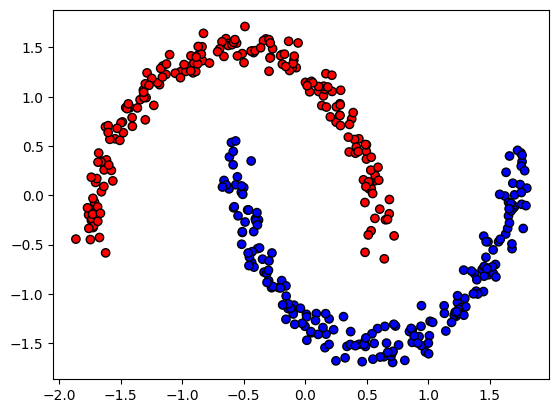

In [ ]:
# data generation, normalization and plotting

noise = 0.5
n_samples = 500

# (X,Y) = twospirals(n_points=n_samples, noise=noise)
X,Y = make_moons(n_samples=n_samples, shuffle=True, noise=noise/10, random_state=None)

X = StandardScaler().fit_transform(X) #zero mean and unit variance

Y = Y.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

fig = plt.figure()
plt.scatter(x_train[:,0],x_train[:,1],c=y_train[:,0],cmap=cm_bright,edgecolors='k')
plt.show()


First, given the nature of the problem, set the appropriate values for the dimensions of the inputs and outputs of your model. Set a value for the number of neurons in the hidden layer.

In [ ]:
# Initialize variables depending on the problem to tackle

input_size = 2 #el valor en x e y
output_size = 1 #2 #La clase en one hot encoding (CAMBIAR A UNO SI DA PROBLEMA, PERO NO DEBERIA. YA QUE p(x=1)=1-p(x=0). Pero hacerlo asi me da generalidad si quiero mas clases.)

nb_neurons_hidden_layer = 20


We will need to define some auxiliary functions: First the activation functions and the cost function we will use. We will use sigmoid activation functions, both for the hidden and output layers. For the output layer, this comes from the fact that we have a binary classification problem. For the hidden layer, this is our choice.

Define the sigmoid function and a "vectorized" version applying it to all the elements of a vector (this one is given). Also define the loss function we will use, the binary cross entropy function. It takes as argument the true labels and the output of your model. Hint: you can implement it easily with an "if" statement on the value of the true label.

\begin{equation*}
L(\mathbf{y},\mathbf{t}) = \sum_{n=1}^{N} l(y_{n},t_{n}) = -\sum_{n=1}^{N}  \left( t_{n} \textrm{ln}(y_{n}) + (1-t_{n}) \textrm{ln}(1-y_{n}) \right)
\end{equation*}

where $\mathbf{y}$ is the output of your model (concatenated for each sample) and $\mathbf{t}$ is the set of all true target variables, for each sample.

In [ ]:
# initialize all variables for forward pass

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_vectorized(x):
    return np.array(list(map(sigmoid, x)))

def CrossEntropy(yHat, y, eps=1e-8):
    #yHat = np.clip(yHat, eps, 1 - eps)
    #return -np.mean(((1-y) * np.log(1-yHat + eps))+(y * np.log(yHat + eps)), axis=0)
    if y == 1:
        return -np.log(yHat)

    return -np.log(1-yHat)



In [ ]:
np.array([1,2])*np.array([3, 4])

array([3, 8])

Code the function implementing the "forward pass", i.e. computing the output of your network, given one input sample $x = \mathbf{x}_{n}$ for some $n$, and all its parameters (weight matrices and biases for all layers). It should return all the intermediary variables, i.e. the outputs of each layer, after ($a_i$, with $i$ the layer index) and before ($z_i$) applying the activation function. We will need those to compute the gradient of the function w.r.t. all the parameters. How many trainable parameters does your network have?

In [ ]:
def forward(x,W1,b1,W2,b2):

    z1 = np.dot(W1 ,x) + b1
    a1 = sigmoid_vectorized(z1)
    z2 = np.dot(W2 ,a1) + b2
    a2 = sigmoid_vectorized(z2)

    return (z1,a1,z2,a2)
#nuestra red tiene: (input_size*nb_neurons_hidden_layer+1)+(nb_neurons_hidden_layer*output_size+1) parametros entrenables

Now, implement the "backward pass", i.e. implement a function that takes as inputs all the parameters of your model, and also the variables computed during the forward pass, and outputs the gradients of your loss function $l$ w.r.t. all these parameters.

You will use the chain rule to compute the derivative of the loss function w.r.t. all the intermediary variables, and implement it "by hand". Automatic differentiation does this in an automated way by keeping track of all the dependencies between variables using a tree structure (you can draw one yourself for this example to see the dependencies!).

Begin by calculating the derivative of the "output" variable s w.r.t the output of the network $y_{n} = a_2$:
\begin{equation*}
\frac{\partial s}{\partial a_2} = \frac{\partial s}{\partial l} \frac{\partial l}{\partial a_2}
\end{equation*}
$\frac{\partial s}{\partial l}$ is the seed (known), so you only need to compute by hand $\frac{\partial l}{\partial a_2}$.
Then you can compute the derivatives of $s$ w.r.t. the variables on which $a_2$ depends directly, here only $z_2$:
\begin{equation*}
\frac{\partial s}{\partial z_2} = \frac{\partial s}{\partial a_2} \frac{\partial a_2}{\partial z_2}
\end{equation*}
You can easily show that the sigmoid function has a simple derivative:
\begin{equation*}
\sigma'(z_2) = \sigma(z_2)(1-\sigma(z_2))
\end{equation*}
Computing this allows you to move on to compute $\frac{\partial s}{\partial W_2}$ and $\frac{\partial s}{\partial b_2}$, and so on...

In [ ]:
ds = 1 # seed for backward differentiation (initial value of ds/dl, in practice set to 1 if s=l at the output)

# if a is a variable, we denote by da the value of ds/da for the current value of the parameters,
# inputs and intermediary variables.


#lo hacemos elemento a elemento, no como vector

def backward(W1,b1,W2,b2,y,ds,z1,a1,z2,a2,x):
    da2=ds*(-y/a2-(1-y)/(a2-1))
    dz2=da2*(a2*(1-a2))
    dw2=dz2*a1
    db2=dz2

    da1=np.dot(dz2,W2)
    dz1=da1*(a1*(1-a1))
    #dw1=dz1*x, como estoy trabajando con matrices, no es tan simple
    dw1=np.zeros((nb_neurons_hidden_layer,input_size))
    for i in range(nb_neurons_hidden_layer):
      dw1[1,:]=dz1[i]*x
    db1=dz1
    return dw2,db2,dw1,db1

Now that we have our model, our loss function and know how to compute the gradients w.r.t. all the trainable parameters, we can finally train our model by gradient descent. Implement a function taking as input all the training samples and labels, a learning rate (gradient descent step size), a number of epochs (iterations of the gradient descent), and the seed of the derivative calculation.

This function should return the final values of the parameters, and the value of the total loss function computed over all training samples, at each epoch (so we can check whether the function is decreasing).

In [ ]:
def network_training(X,Y,lr,epochs,ds):
    n_ep_print = 100
    # random initialization of the parameters

    W1 = np.random.randn(nb_neurons_hidden_layer,input_size)
    b1 = np.random.randn(nb_neurons_hidden_layer)

    W2 = np.random.randn(output_size,nb_neurons_hidden_layer)
    b2 = np.random.randn(output_size)

    loss = np.zeros(epochs) # total loss function value

    # loop over epochs

    for k in range(epochs):

        # initialize gradients and loss

        N = np.shape(X)[0]
        loss_ = 0
        dw2 =  np.ones((output_size,nb_neurons_hidden_layer))
        db2 =  np.ones(output_size)
        dw1 =  np.ones((nb_neurons_hidden_layer,input_size))
        db1 =  np.ones((nb_neurons_hidden_layer))

        # inner loop over all samples

        for i in range(N):

            # compute the output of the model for the current input

            z1, a1, z2, a2 = forward(X[i,:],W1,b1,W2,b2)

            # compute the loss function value

            loss_ = CrossEntropy(a2, Y[i,:])

            # add the current loss to the total loss

            loss[k] = loss[k]+loss_

            # compute the gradients

            dw2_,db2_,dw1_,db1_ = backward(W1,b1,W2,b2,Y[i,:],ds,z1,a1,z2,a2,X[i,:])

            # add the current gradient values to the total gradient values

            dw2 = dw2 + dw2_
            db2 = db2 + db2_
            dw1 = dw1 + dw1_
            db1 = db1 + db1_

        # print loss every n_ep_print epochs

        if k % n_ep_print == 0:
            print("Epoch {:3d} Loss: {:f}".format(k, loss[k]))

        # perform gradient descent with the same step size for all parameters

        W2 = W2 - lr * dw2
        b2 = b2 - lr * db2
        W1 = W1 - lr * dw1
        b1 = b1 - lr * db1

    return(W2,b2,W1,b1,loss)


Train your network by choosing an appropriate learning rate and number of epochs. Plot the value of the loss function across training epochs.

In [ ]:
epochs = 1000
lr = 0.01

W2,b2,W1,b1,loss = network_training(x_train,y_train,lr,epochs,ds)

Epoch   0 Loss: 1341.172424
Epoch 100 Loss: 78.611235
Epoch 200 Loss: 63.247773
Epoch 300 Loss: 37.242479
Epoch 400 Loss: 29.517304
Epoch 500 Loss: 29.461561
Epoch 600 Loss: 31.341657
Epoch 700 Loss: 35.496323
Epoch 800 Loss: 40.956433
Epoch 900 Loss: 44.048331


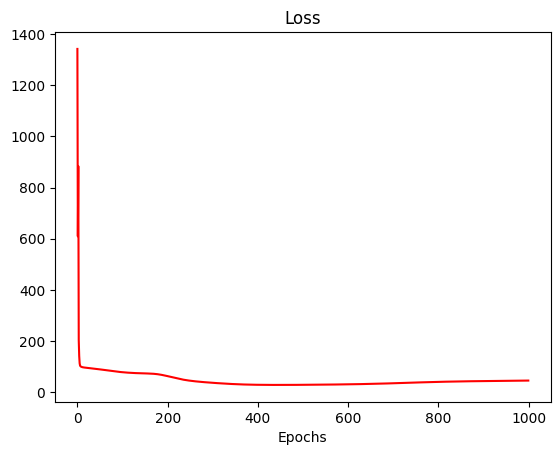

In [ ]:
# plot training loss
import matplotlib.pyplot as plt

plt.plot(loss, 'r')
plt.title("Loss")
plt.xlabel("Epochs")
plt.show()

Now it's time to test the network, i.e. make predictions on the test set and check the classification accuracy.
For this, you just have to use the forward function an all test samples, using the values of the parameters you obtained from the training phase.

Since the output of the network is a real number between 0 and 1, do not forget to threshold it to make the binary classification decision! Then you can compute the classification accuracy on the test set.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

N_test = np.shape(x_test)[0]

# compute network predictions for all test samples

y_pred = np.zeros((N_test))
for i in range(N_test):
    _,_,_,y_pred[i] = forward(X[i,:],W1,b1,W2,b2)

# Make binary decision
y_pred_binary = (y_pred > 0.5).astype(int)

print(np.sum(y_pred_binary == Y[1,:]) / N_test)

# classification accuracy
'''
corr_matrix = np.zeros((2,2))
for i in range(N_test):
    corr_matrix[y_pred_binary[i], Y[i][0]] += 1

ax = plt.subplot()
sns.heatmap(corr_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix on the Test Set');
ax.xaxis.set_ticklabels(['Class 0', 'Class 1']); ax.yaxis.set_ticklabels(['Class 0', 'Class 1']);
'''
#

ValueError: ignored

Finally, you can visualize the nonlinear decision boundaries of your trained model together with the dataset

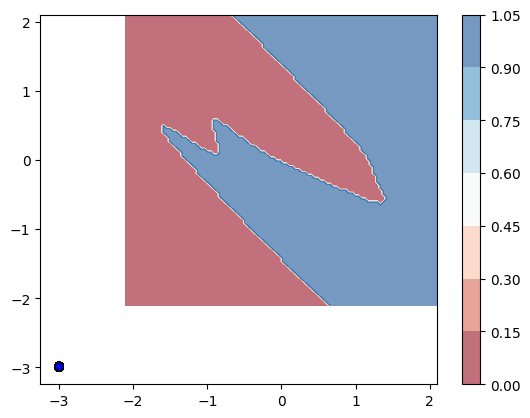

In [ ]:
grid_size = 100

x = np.linspace(-2.1,2.1,grid_size)
y = np.linspace(-2.1,2.1,grid_size)

def plot_decision_boundary(x,y,X,labels):
    # to be completed
    # x and y are the vectors giving the extent of the 2D grid
    # X is the data, labels the true labels to plot the data on top of the boundaries

    # define grid of points

    [xx,yy] = np.meshgrid(x,y)
    Z = np.zeros(grid_size*grid_size)

    # compute binary predictions for all the points of the grid

    for i in range(np.shape(Z)[0]):
        dummy0, dummy1, dummy3,Z[i] = forward(np.c_[xx.ravel(), yy.ravel()][i],W1,b1,W2,b2)

    Z[Z>0.5] = 1
    Z[Z<=0.5] = 0

    Z = Z.reshape(grid_size,grid_size)

    # scatterplot of the data and contour lines of the decision function

    plt.scatter(X[:,0],X[:,1], c = labels,cmap=cm_bright,edgecolors='k')
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha = 0.6)

# use the function to show all the info

plot_decision_boundary(x,y,X,Y[:,0])
plt.colorbar()

Try to change the dataset for the spiral dataset (in the second cell), and check whether or not your network works on that example.